In [13]:
import pandas as pd
import numpy as np
import os
import sys

sys.path.append("../../../../")
from analysis_functions import *

In [14]:
# Загрузка данных
X_stress_components_new = opener(
    "X_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
X_strain_components_new = opener(
    "X_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
y_stress_components_new = opener(
    "y_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
y_strain_components_new = opener(
    "y_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
# X_stress_components_other = opener('X_stress_components_other')
# X_strain_components_other = opener('X_strain_components_other')
# y_stress_components_other = opener('y_stress_components_other')
# y_strain_components_other = opener('y_strain_components_other')


../../../../new_components_resources/X_stress_components_new_components.pkl
../../../../new_components_resources/X_strain_components_new_components.pkl
../../../../new_components_resources/y_stress_components_new_components.pkl
../../../../new_components_resources/y_strain_components_new_components.pkl


In [15]:
component_num = 0

X, y = (X_stress_components_new[component_num], 
        y_stress_components_new[component_num])

## Простое обучение

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Разделение данных на обучающую, валидационную и тестовую выборки
cur_X_train, cur_X_test, cur_y_train, cur_y_test = split_transform_one_comp_train_test(
    X, y
)

# Обучение модели
model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    loss="squared_error",
    random_state=RANDOM_STATE,
)
model.fit(cur_X_train, cur_y_train)

# Предсказание
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = np.sqrt(mean_squared_error(cur_y_test, cur_y_pred))
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_train)
rmse_train = np.sqrt(mean_squared_error(cur_y_train, cur_y_pred_train))
print(f"RMSE train: {rmse_train:.2f}")


RMSE test: 15.11
RMSE train: 15.13


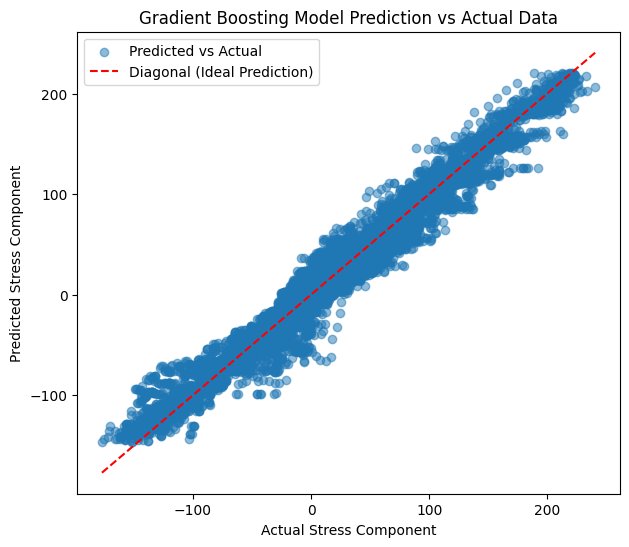

In [17]:
import matplotlib.pyplot as plt

# Predicting the values
cur_y_pred = model.predict(cur_X_test)

# Plotting the results
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, cur_y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Diagonal (Ideal Prediction)",
)
plt.xlabel("Actual Stress Component")
plt.ylabel("Predicted Stress Component")
plt.title("Gradient Boosting Model Prediction vs Actual Data")
plt.legend()
plt.show()

## С оптимизацией гиперпараметров

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

n_splits = 5
# Preparing datasets
cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
    split_transform_one_comp_cv(X, y, n_splits=n_splits)
)

def do_optuna_for_boosting(X, y, n_trials=200, **kwargs):
    n_splits = kwargs.get("n_splits", 3)

    def optuna_boosting_val(trial):
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 1, 10)
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)

        params = {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "random_state": RANDOM_STATE,
        }

        # Fitting and scoring `n_split` times
        errors = np.zeros((n_splits, 9))

        for split_idx in range(n_splits):
            regr = GradientBoostingRegressor(**params)

            cur_X_train = train_list_X[split_idx]
            cur_y_train = train_list_y[split_idx]

            cur_X_val = val_list_X[split_idx]
            cur_y_val = val_list_y[split_idx]

            cur_X_train, cur_y_train = clean_input_array(cur_X_train, cur_y_train)
            cur_X_val, cur_y_val = clean_input_array(cur_X_val, cur_y_val)

            regr.fit(cur_X_train, cur_y_train)

            #######  Validation  ########
            #  Prediction
            cur_prediction = regr.predict(cur_X_val)
            # Scoring
            errors[split_idx] = scorer(cur_y_val, cur_prediction, regr, cur_X_train)

        # Collect validation result
        val_metrics = choose_worst(errors)
        return_value = (
            val_metrics[-1] if pd.notnull(val_metrics[-1]) else +1e6
        )  # для rmse
        return return_value

    # Create a study object to optimize the objective
    study = optuna.create_study(direction="minimize")  # rmse
    study.optimize(optuna_boosting_val, n_trials=n_trials, n_jobs=-1)

    # Print the best hyperparameters found by Optuna
    best_params = study.best_params
    best_value = study.best_value
    print("Best Hyperparameters:", best_params)

    return best_params, cur_X_test, cur_y_test, best_value

# Use the function
best_params, cur_X_test, cur_y_test, best_value = do_optuna_for_boosting(X, y, n_splits=n_splits)

# Предсказание
model = GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE)
model.fit(cur_X_train, cur_y_train)
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = np.sqrt(mean_squared_error(cur_y_test, cur_y_pred))
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_train)
rmse_train = np.sqrt(mean_squared_error(cur_y_train, cur_y_pred_train))
print(f"RMSE train: {rmse_train:.2f}")

[I 2025-05-16 15:08:00,824] A new study created in memory with name: no-name-b3faf02d-5bf2-4266-b983-10221020fb8b
[I 2025-05-16 15:08:02,433] Trial 6 finished with value: 37.700790000560715 and parameters: {'n_estimators': 74, 'max_depth': 1, 'learning_rate': 0.04061540548935095}. Best is trial 6 with value: 37.700790000560715.
[I 2025-05-16 15:08:06,551] Trial 1 finished with value: 53.96333841467704 and parameters: {'n_estimators': 77, 'max_depth': 5, 'learning_rate': 0.005137742420778619}. Best is trial 6 with value: 37.700790000560715.
[I 2025-05-16 15:08:07,694] Trial 4 finished with value: 66.61098427805649 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.0012534476953072636}. Best is trial 6 with value: 37.700790000560715.
[I 2025-05-16 15:08:09,342] Trial 0 finished with value: 70.32179551799547 and parameters: {'n_estimators': 116, 'max_depth': 5, 'learning_rate': 0.0008529085195245516}. Best is trial 6 with value: 37.700790000560715.
[I 2025-05-16 15:0

Best Hyperparameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.09789929744753907}
RMSE test: 5.66
RMSE train: 2.19


In [19]:
import joblib
# Best Hyperparameters: {'n_estimators': 254, 'max_depth': 10, 'learning_rate': 0.07123668319491888}
# best_params = {'n_estimators': 254, 'max_depth': 10, 'learning_rate': 0.07123668319491888}
# Train the model with the best hyperparameters
model = GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE)
cur_X_train = train_list_X[-1]
cur_y_train = train_list_y[-1]
model.fit(cur_X_train, cur_y_train)

pred = model.predict(cur_X_test)
rmse = np.sqrt(mean_squared_error(cur_y_test, pred))
print(f"RMSE Test: {rmse:.2f}")


print(f"RMSE Train: {rmse:.2f}")
mse_best = mean_squared_error(cur_y_test, pred)
print(f"MSE test with best model: {mse_best:.2f}")
mae_best = mean_absolute_error(cur_y_test, pred)
print(f"MAE test with best model: {mae_best:.2f}")
r2_best = r2_score(cur_y_test, pred)
print(f"R2 test with best model: {r2_best:.2f}")

pred_train = model.predict(cur_X_train)
rmse = np.sqrt(mean_squared_error(cur_y_train, pred_train))


# Save the model to a file
model_filename = "best_gradient_boosting_model.pkl"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

RMSE Test: 5.83
RMSE Train: 5.83
MSE test with best model: 33.98
MAE test with best model: 3.19
R2 test with best model: 0.99
Model saved to best_gradient_boosting_model.pkl


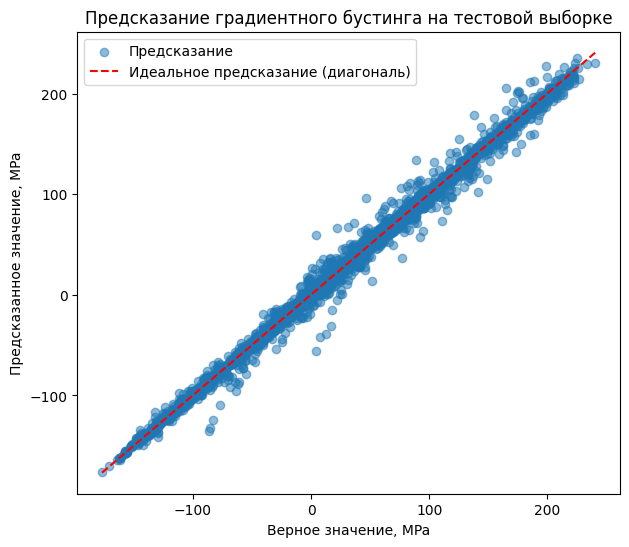

In [20]:
import matplotlib.pyplot as plt

# Plotting the results using the best model
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, pred, alpha=0.5, label="Предсказание")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Идеальное предсказание (диагональ)",
)
plt.xlabel("Верное значение, MPa")
plt.ylabel("Предсказанное значение, MPa")
plt.title("Предсказание градиентного бустинга на тестовой выборке")
plt.legend()
plt.savefig(f"best_gradient_boosting_prediction_{component_num}.png", dpi=400)
plt.show()
